# Predicting Democratic Backsliding

## Import Packages

In [147]:
# Data Wrangling
import pandas as pd
import numpy as np
import country_converter as coco
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Model Interpretation
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import permutation_importance
from pdpbox import pdp

## Load the democracy data and select features

In [148]:
vdem = pd.read_csv("Data/Country_Year_V-Dem_Full+others_CSV_v10/V-Dem-CY-Full+Others-v10.csv")

In [149]:
vdem = vdem.loc[vdem['year'] >= 1960]

In [150]:
# before splitting into buckets create decades variables- leave the 2010s as the reference
vdem["60s"] = np.where((vdem.year >= 1960) & (vdem.year <1970), 1, 0) 
vdem["70s"] = np.where((vdem.year >= 1970) & (vdem.year <1980), 1, 0) 
vdem["80s"] = np.where((vdem.year >= 1980) & (vdem.year <1990), 1, 0)
vdem["90s"] = np.where((vdem.year >= 1990) & (vdem.year <2000), 1, 0)
vdem["00s"] = np.where((vdem.year >= 2000) & (vdem.year <2010), 1, 0)

In [151]:
civil_liberties = vdem[["country_name", "year", "v2x_frassoc_thick", "v2x_suffr", "v2xel_frefair", "v2cltort", "v2clkill", "v2cltrnslw", "v2clrspct", "v2clacjust", "v2clsocgrp", "v2clacfree", "v2clrelig", "v2caassemb", "v2xcl_acjst", "v2x_clpol", "v2x_freexp", "60s", "70s", "80s", "90s", "00s"]]

In [152]:
civil_society = vdem[["country_name", "year", "v2x_cspart", "v2cseeorgs", "v2csreprss", "v2cscnsult", "v2csstruc_0", "v2csstruc_1", "v2csstruc_2", "v2csprtcpt", "v2csantimv", "v2csrlgrep", "60s", "70s", "80s", "90s", "00s"]]

In [153]:
media = vdem[["country_name", "year", "v2mecenefm", "v2mecenefi", "v2mecenefibin", "v2mecrit", "v2merange", "v2meharjrn", "v2mebias", "60s", "70s", "80s", "90s", "00s"]]

In [154]:
access_services = vdem[["country_name", "year", "v2pepwrses", "v2pepwrsoc", "v2peedueq", "v2pehealth", "v2peapsecon", "v2peasjsoecon", "v2peasbecon", "v2clgencl", "v2peapsgen", "v2pepwrgeo", "v2clgeocl", "v2peapsgeo", "v2peasjgeo", "v2peasbegeo", "v2clpolcl", "v2peapspol", "v2peasjpol", "v2peasbepol", "60s", "70s", "80s", "90s", "00s"]]

In [155]:
strife = vdem[["country_name", "year", "v2cacamps", "v2caviol", "v2cagenmob", "v2cademmob", "v2caautmob", "v2castate", "v2catrauni", "v2capolit", "v2canonpol", "60s", "70s", "80s", "90s", "00s"]]

In [156]:
# all the selected features
total_vdem = vdem[["country_name", "year", "v2x_frassoc_thick", "v2x_suffr", "v2xel_frefair", "v2cltort", "v2clkill", "v2cltrnslw", "v2clrspct", "v2clacjust", "v2clsocgrp", "v2clacfree", "v2clrelig", "v2caassemb", "v2xcl_acjst", "v2x_clpol", "v2x_freexp", "v2x_cspart", "v2cseeorgs", "v2csreprss", "v2cscnsult", "v2csstruc_0", "v2csstruc_1", "v2csstruc_2", "v2csprtcpt", "v2csantimv", "v2csrlgrep", "v2mecenefm", "v2mecenefi", "v2mecenefibin", "v2mecrit", "v2merange", "v2meharjrn", "v2mebias", "v2pepwrses", "v2pepwrsoc", "v2peedueq", "v2pehealth", "v2peapsecon", "v2peasjsoecon", "v2peasbecon", "v2clgencl", "v2peapsgen", "v2pepwrgeo", "v2clgeocl", "v2peapsgeo", "v2peasjgeo", "v2peasbegeo", "v2clpolcl", "v2peapspol", "v2peasjpol", "v2peasbepol","v2cacamps", "v2caviol", "v2cagenmob", "v2cademmob", "v2caautmob", "v2castate", "v2catrauni", "v2capolit", "v2canonpol", "60s", "70s", "80s", "90s", "00s"]]   

In [157]:
polity_data = pd.read_csv("Data/p5v2018.csv")

In [158]:
polity_data = polity_data[["country", "year", "polity2", "durable"]]

In [159]:
polity_data = polity_data.loc[polity_data['year'] >= 1960]

In [160]:
polity_data

,country,year,polity2,durable
160,Afghanistan,1960,-10.0,NaN
161,Afghanistan,1961,-10.0,NaN
162,Afghanistan,1962,-10.0,NaN
163,Afghanistan,1963,-10.0,NaN
164,Afghanistan,1964,-7.0,0.0
...,...,...,...,...
17543,Zimbabwe,2014,4.0,1.0
17544,Zimbabwe,2015,4.0,2.0
17545,Zimbabwe,2016,4.0,3.0
17546,Zimbabwe,2017,4.0,4.0


## Load the econ data 

In [161]:
# read in GDP per capita growth data
GDPPC_growth = pd.read_csv("Data/gdp_per_capita_yearly_growth- Gapminder.csv")

In [162]:
# melt so that we have country year as units of observation
GDPPC_growth = GDPPC_growth.melt(id_vars= 'country', var_name = 'year', value_name='GDPpc_growth')

In [163]:
# change year to numeric
GDPPC_growth['year'] = pd.to_numeric(GDPPC_growth['year'])

In [164]:
# keep only observations from 1960 onwards
GDPPC_growth = GDPPC_growth.loc[GDPPC_growth['year'] >= 1960]

In [165]:
# read in real GDP growth data
GDP_growth = pd.read_csv("Data/gdp_total_yearly_growth- Gapminder.csv")

In [166]:
# melt so that we have country year as units of observation
GDP_growth = GDP_growth.melt(id_vars= 'country', var_name = 'year', value_name='GDP_growth')

In [167]:
# change year to numeric
GDP_growth['year'] = pd.to_numeric(GDP_growth['year'])

In [168]:
# keep only observations from 1960 onwards
GDP_growth = GDP_growth.loc[GDP_growth['year'] >= 1960]

In [169]:
Poverty = pd.read_csv("Data/Poverty Headcount Ratio WB.csv", skiprows=4)

In [170]:
Poverty.drop(columns = ["Indicator Name", "Indicator Code", "Country Code", "Unnamed: 65"], inplace=True)

In [171]:
Poverty = Poverty.melt(id_vars= 'Country Name', var_name = 'year', value_name='Poverty Rate')

In [172]:
Poverty['year'] = pd.to_numeric(Poverty['year'])

In [173]:
Unemployment = pd.read_csv("Data/Unemployment-gapminderILO.csv")

In [174]:
Unemployment = Unemployment.melt(id_vars= 'country', var_name = 'year', value_name='Unemployment')

In [175]:
Unemployment['year'] = pd.to_numeric(Unemployment['year'])

In [176]:
# keep only observations from 1960 onwards
Unemployment = Unemployment.loc[Unemployment['year'] >= 1960]

In [177]:
Gini = pd.read_csv("Data/World Bank Gini.csv", skiprows=4)

In [178]:
Gini.drop(columns = ["Indicator Name", "Indicator Code", "Country Code", "Unnamed: 65"], inplace=True)

In [179]:
Gini = Gini.melt(id_vars= 'Country Name', var_name = 'year', value_name='Gini')

In [180]:
Gini['year'] = pd.to_numeric(Gini['year'])

## Make sure countries line up

In [181]:
len(vdem.country_name.unique())
# vdems has less countries than gapminder and GDP

182

In [182]:
len(polity_data.country.unique())

180

In [183]:
len(GDP_growth.country.unique())

194

In [184]:
len(GDPPC_growth.country.unique())

194

In [185]:
len(Poverty["Country Name"].unique())

264

In [186]:
len(Unemployment.country.unique())

186

In [187]:
len(Gini["Country Name"].unique())

264

In [188]:
GDP_names = GDP_growth.country.to_list()
GDP_names = coco.convert(GDP_names, to = 'name_short', not_found = None)

In [189]:
GDPPC_names = GDPPC_growth.country.to_list()
GDPPC_names = coco.convert(GDPPC_names, to = 'name_short', not_found = None)

In [190]:
Poverty_names = Poverty["Country Name"].to_list()
Poverty_names = coco.convert(Poverty_names, to = 'name_short', not_found = None)

t found in regex
East Asia & Pacific ( not found in regex
Early-demographic dividend not found in regex
East Asia & Pacific not found in regex
Europe & Central Asia ( not found in regex
Europe & Central Asia not found in regex
Euro area not found in regex
European Union not found in regex
Fragile and conflict affected situations not found in regex
High income not found in regex
Heavily indebted poor countries (HIPC) not found in regex
IBRD only not found in regex
IDA & IBRD total not found in regex
IDA total not found in regex
IDA blend not found in regex
IDA only not found in regex
Not classified not found in regex
Latin America & Caribbean ( not found in regex
Latin America & Caribbean not found in regex
Least developed countries: UN classification not found in regex
Low income not found in regex
Lower middle income not found in regex
Low & middle income not found in regex
Late-demographic dividend not found in regex
Middle East & North Africa not found in regex
Middle income not fou

In [120]:
Unemployment_names = Unemployment.country.to_list()
Unemployment_names = coco.convert(Unemployment_names, to = 'name_short', not_found = None)

In [121]:
Gini_names = Gini["Country Name"].to_list()
Gini_names = coco.convert(Gini_names, to = 'name_short', not_found = None)

t found in regex
East Asia & Pacific ( not found in regex
Early-demographic dividend not found in regex
East Asia & Pacific not found in regex
Europe & Central Asia ( not found in regex
Europe & Central Asia not found in regex
Euro area not found in regex
European Union not found in regex
Fragile and conflict affected situations not found in regex
High income not found in regex
Heavily indebted poor countries (HIPC) not found in regex
IBRD only not found in regex
IDA & IBRD total not found in regex
IDA total not found in regex
IDA blend not found in regex
IDA only not found in regex
Not classified not found in regex
Latin America & Caribbean ( not found in regex
Latin America & Caribbean not found in regex
Least developed countries: UN classification not found in regex
Low income not found in regex
Lower middle income not found in regex
Low & middle income not found in regex
Late-demographic dividend not found in regex
Middle East & North Africa not found in regex
Middle income not fou

In [122]:
# standardize country names
GDPPC_growth.country = GDPPC_names
GDP_growth.country = GDP_names
Poverty["Country Name"] = Poverty_names
Unemployment.country = Unemployment_names
Gini["Country Name"] = Gini_names

In [123]:
# standardize country names with country-converter than keep the countries that overlap
vdem_names = civil_liberties.country_name.to_list()
vdem_names = coco.convert(vdem_names, to = 'name_short', not_found = None)

Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German D

In [124]:
polity_names = polity_data.country.tolist()
polity_names = coco.convert(polity_names, to = 'name_short')

Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found 

In [125]:
polity_data["country"] = polity_names
access_services["country_name"] = vdem_names
civil_liberties["country_name"] = vdem_names
civil_society["country_name"] = vdem_names
media["country_name"] = vdem_names
strife["country_name"] = vdem_names
total_vdem["country_name"] = vdem_names

In [126]:
polity_names = pd.Series(polity_names)
vdem_names = pd.Series(vdem_names)

In [127]:
intersection = pd.Series(np.intersect1d(polity_names, vdem_names))

In [128]:
polity_data = polity_data[polity_data["country"].isin(intersection)]
access_services = access_services[access_services["country_name"].isin(intersection)]
civil_liberties = civil_liberties[civil_liberties["country_name"].isin(intersection)]
civil_society = civil_society[civil_society["country_name"].isin(intersection)]
media = media[media["country_name"].isin(intersection)]
strife = strife[strife["country_name"].isin(intersection)]
total_vdem = total_vdem[total_vdem["country_name"].isin(intersection)]

## Wrangle institution data

In [53]:
# Set country and year as index for X variables
access_services.set_index(["country_name", "year"], inplace=True)
civil_liberties.set_index(["country_name", "year"], inplace=True)
civil_society.set_index(["country_name", "year"], inplace=True)
media.set_index(["country_name", "year"], inplace=True)
strife.set_index(["country_name", "year"], inplace=True)
total_vdem.set_index(["country_name", "year"], inplace=True)

In [54]:
# lag variables- previous year
strife = strife.groupby("country_name").shift()
media = media.groupby("country_name").shift()
civil_society = civil_society.groupby("country_name").shift()
civil_liberties = civil_liberties.groupby("country_name").shift()
access_services =access_services.groupby("country_name").shift()
total_vdem = total_vdem.groupby("country_name").shift()

In [55]:
# for the y let's drop durable for now
polity_data.drop(columns = "durable", inplace=True)

In [56]:
# Create variable to show change in polity score
shifted_polity = polity_data.groupby("country").apply(lambda x: x - x.shift(1))

In [57]:
polity_data["change in polity"] = shifted_polity.polity2

In [58]:
# create binary variable for presence of backsliding
polity_data["backsliding"] = np.where(polity_data["change in polity"] >= 0, 0, 1) 

In [59]:
# set country year index for Y
polity_data.set_index(["country", "year"], inplace=True)

In [61]:
polity_data.drop(columns = ["polity2", "change in polity"], inplace=True)

In [62]:
# Merge Data
access_services = polity_data.merge(access_services, how = "inner", left_index = True, right_on = ['country_name', 'year'])
civil_liberties = polity_data.merge(civil_liberties, how = "inner", left_index = True, right_on = ['country_name', 'year'])
civil_society = polity_data.merge(civil_society, how = "inner", left_index = True, right_on = ['country_name', 'year'])
media = polity_data.merge(media, how = "inner", left_index = True, right_on = ['country_name', 'year'])
strife = polity_data.merge(strife, how = "inner", left_index = True, right_on = ['country_name', 'year'])
total_vdem = polity_data.merge(total_vdem, how = "inner", left_index = True, right_on = ['country_name', 'year'])

## Wrangle Economic Data

In [63]:
GDPPC_growth.set_index(["country", "year"], inplace= True)
GDP_growth.set_index(["country", "year"], inplace= True)
Poverty.set_index(["Country Name", "year"], inplace= True)
Unemployment.set_index(["country", "year"], inplace= True)
Gini.set_index(["Country Name", "year"], inplace= True)

In [64]:
# Merge all the econ data
Econ_merge = GDPPC_growth.merge(GDP_growth, how="inner", left_index=True, right_index=True).merge(Poverty, how = "inner", left_index=True, right_on=["Country Name", "year"]).merge(Unemployment, how = "inner", left_index=True, right_on= ["country", "year"]).merge(Gini, how="inner", left_index = True, right_on = ["Country Name", "year"])

In [65]:
 # Lag Data
 Econ_merge = Econ_merge.groupby("Country Name").shift()

In [66]:
# Merge with Polity
econ = Econ_merge.merge(polity_data, how = "inner", left_index = True, right_on = ["country", "year"])

## Split the data for strife

In [467]:
# split strife
y = strife.backsliding
X = strife.drop(columns="backsliding")
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

## Explore the training data

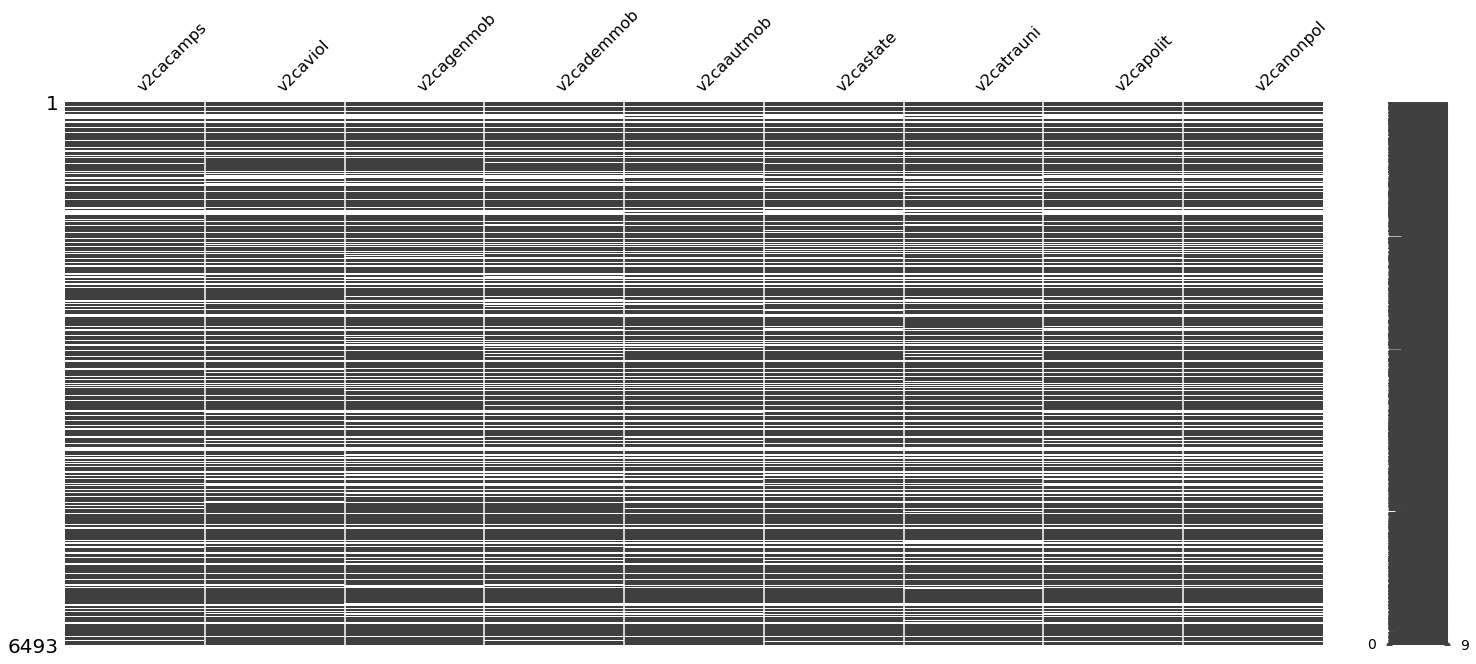

In [468]:
miss.matrix(train_X)

In [469]:
train_X

,,v2cacamps,v2caviol,v2cagenmob,v2cademmob,v2caautmob,v2castate,v2catrauni,v2capolit,v2canonpol
country_name,year,,,,,,,,,
Mexico,1973,-0.788,1.049,0.543,1.710,1.994,1.028,0.138,-0.730,-0.470
Oman,1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Guinea,1970,2.287,0.687,-0.406,-1.418,1.584,2.498,-1.059,-0.791,0.887
Turkmenistan,1999,-1.938,-2.410,-1.500,-2.400,1.767,0.834,-2.103,-1.479,-1.674
Papua New Guinea,1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
Finland,2000,-1.632,-1.284,-1.276,NaN,-1.840,-2.516,NaN,1.620,2.876
Tanzania,2018,-0.620,-1.041,-0.454,0.004,0.538,1.172,0.216,1.425,0.677
Bolivia,2000,-1.346,-0.724,0.611,-0.531,0.332,-1.795,1.789,0.200,1.115


In [470]:
train_X.dropna(inplace=True)

In [471]:
train_X.describe()

,v2cacamps,v2caviol,v2cagenmob,v2cademmob,v2caautmob,v2castate,v2catrauni,v2capolit,v2canonpol
count,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000
mean,-0.281381,-0.297330,-0.206315,-0.375581,-0.378801,-0.097031,0.451091,0.364141,0.497884
std,1.338783,1.386784,1.269520,1.309998,1.289777,1.467630,1.402762,1.291421,1.148749
min,-3.527000,-3.065000,-3.200000,-2.584000,-2.172000,-2.979000,-2.802000,-2.791000,-2.894000
25%,-1.386000,-1.392250,-1.159750,-1.438000,-1.441000,-1.271000,-0.463000,-0.493000,-0.227000
50%,-0.248000,-0.403000,-0.263000,-0.555000,-0.668000,-0.242000,0.694000,0.476000,0.611000
75%,0.669000,0.661000,0.731250,0.612000,0.512000,1.122000,1.369000,1.263000,1.317000
max,3.816000,3.698000,3.547000,3.691000,3.809000,3.435000,3.722000,3.448000,3.645000


In [472]:
a = train_X.melt()

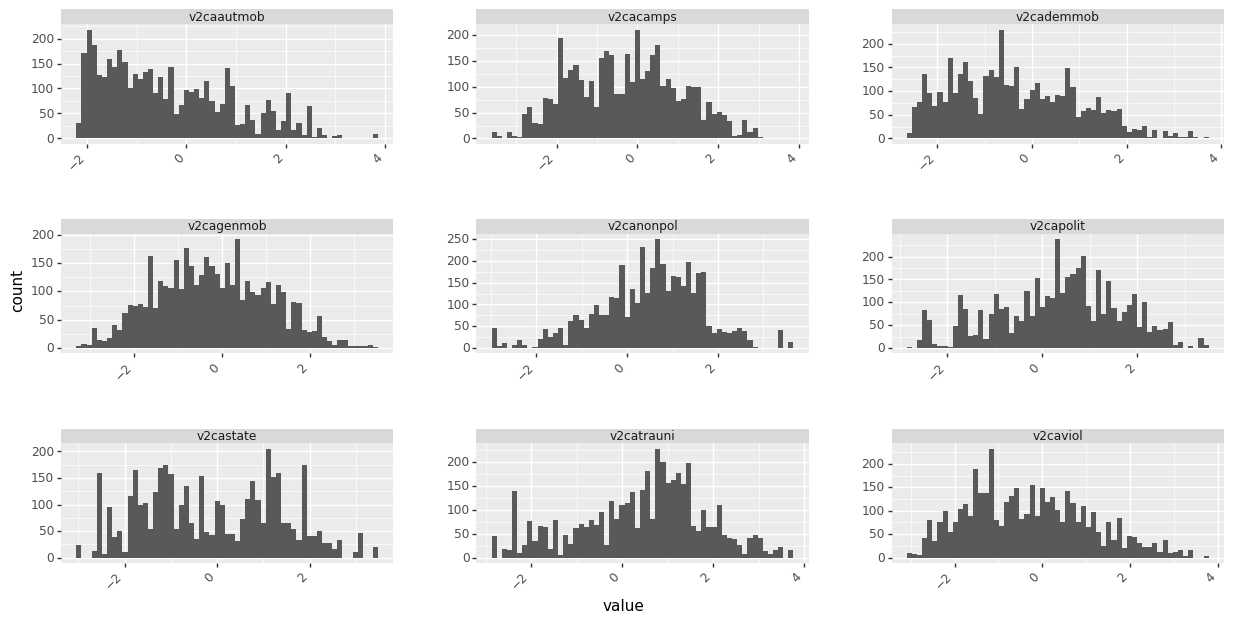

<ggplot: (318412740)>

In [473]:
(
    ggplot(a,aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable" , scales='free') +
    theme(figure_size=(15,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

## Make edits to full data

In [474]:
strife.dropna(inplace = True)

# Model

In [475]:
# split strife again
y = strife["backsliding"]
X = strife.drop(columns="backsliding")
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

In [476]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=1234)

# Set preprocess equal to Min Max Scaler to keep our variable distributions
preprocess = pp.MinMaxScaler()

In [477]:
# Build the modeling pipeline
pipe = Pipeline(steps=[('pre_process', preprocess),('model',None)])

search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators, max depth, and max features tuning param
    {'model' : [RF()],
    'model__max_depth':[6,7,8],
    'model__n_estimators':[500,1000,1500],
    'model__max_features': [5,10,15]},
    
]

# Grid Search to find the best parameters. The metric used for evaluation is ROC AUC
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

# fit the data with the model
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestClassifier(max_depth=8,
                                                           max_features=5,
                                                           n_estimators=1000)],
                          'model__max_depth': [6, 7, 8],
                          'model__max_features': [5, 10, 15],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='roc_auc')

In [478]:
#this is our out of sample AUC score
search.best_score_ 

0.7585283993712302

In [479]:
# what model performs the best
search.best_params_

{'model': RandomForestClassifier(max_depth=8, max_features=5, n_estimators=1000),
 'model__max_depth': 8,
 'model__max_features': 5,
 'model__n_estimators': 1000}

In [480]:
# now what happens if we try on the test data
best_mod = search.best_estimator_

In [481]:
pred_y = best_mod.predict(test_X)
m.roc_auc_score(test_y, pred_y)

0.5336102874557286

In [482]:
m.mean_squared_error(test_y, pred_y)

0.04926108374384237

In [483]:
bad_score_list = []

In [484]:
bad_score = m.accuracy_score(test_y, pred_y)
bad_score_list.append(bad_score)

In [485]:
score_list = []

In [486]:
score = m.balanced_accuracy_score(test_y, pred_y)
print(score)
score_list.append(score)

0.5336102874557286


In [487]:
confusion_list = []

In [488]:
confusion = m.confusion_matrix(test_y, pred_y)
print(confusion)
confusion_list.append(confusion)

[[1346    3]
 [  67    5]]


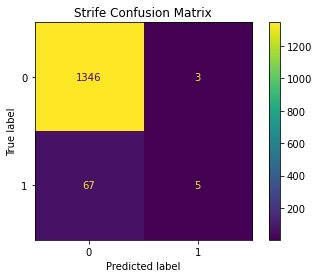

In [489]:
m.plot_confusion_matrix(best_mod, test_X, test_y)
plt.title("Strife Confusion Matrix")
plt.savefig("Figures/Strife_Confusion_matrix")

## Variable Importance

In [490]:
# Use variable permutation to derive the importance of each variable
vi = permutation_importance(best_mod,train_X,train_y,n_repeats=5)

In [491]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)

# view the dataframe
vi_dat

,variable,vi,std,low,high
0,v2cacamps,0.009289,0.000604,0.008080,0.010498
1,v2castate,0.007835,0.000483,0.006869,0.008801
2,v2caviol,0.006615,0.000478,0.005658,0.007572
3,v2caautmob,0.005114,0.000733,0.003648,0.006579
4,v2cagenmob,0.004316,0.000239,0.003838,0.004795
5,v2cademmob,0.003378,0.000483,0.002412,0.004344
6,v2canonpol,0.002440,0.000318,0.001803,0.003076
7,v2catrauni,0.002440,0.000281,0.001877,0.003003
8,v2capolit,0.002440,0.000115,0.002210,0.002669


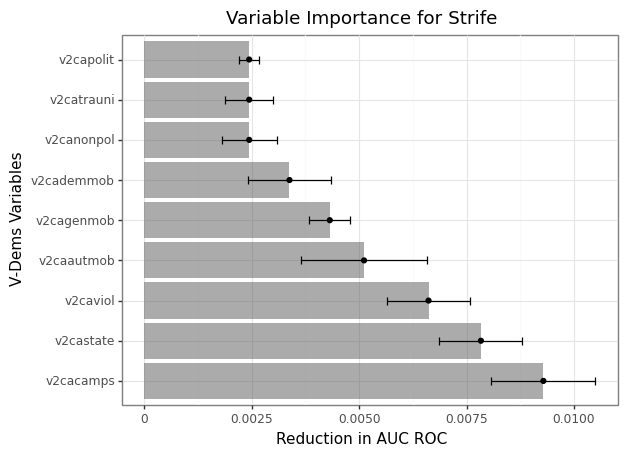

<ggplot: (349287750)>

In [492]:
# Plot variable importance
strife_importance = (
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="V-Dems Variables",title="Variable Importance for Strife")
)
strife_importance.save("Figures/strife_importance")
strife_importance

## Split the data for Access to Services

In [493]:
# split 
y = access_services.backsliding
X = access_services.drop(columns="backsliding")
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

## Explore training data

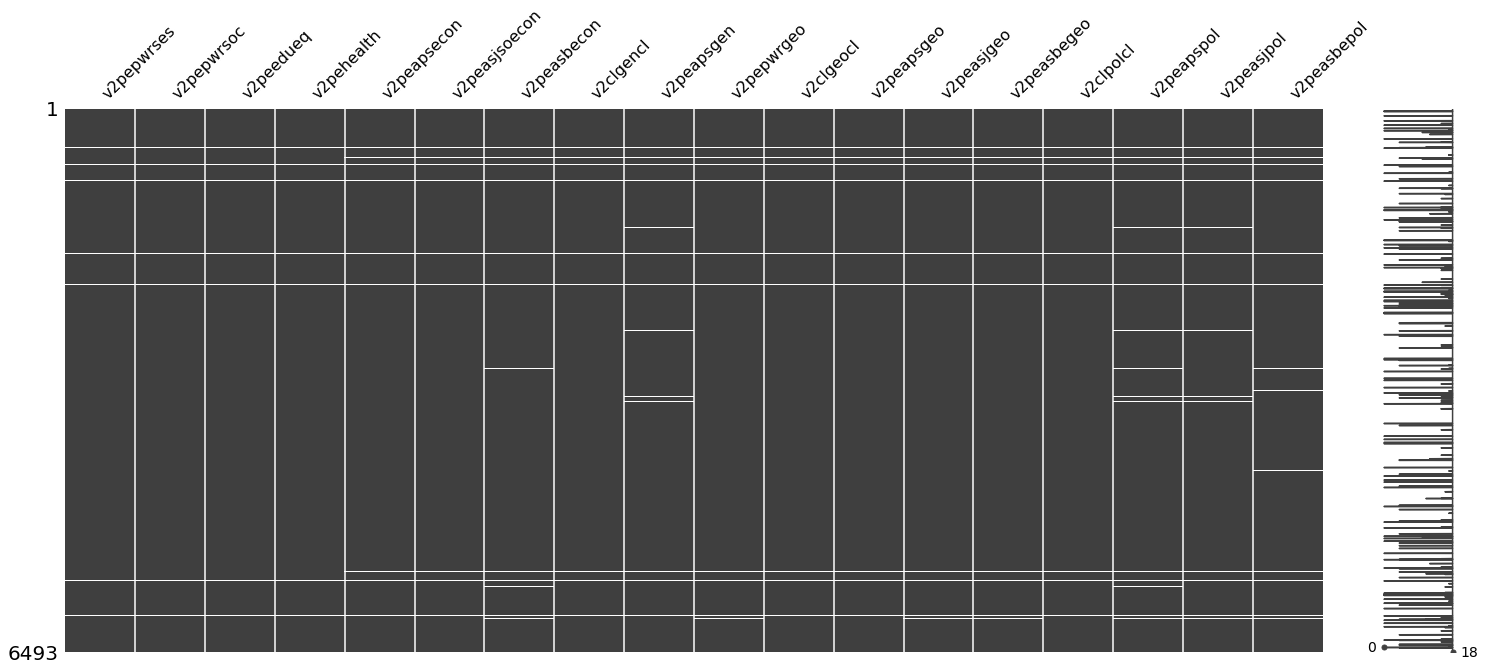

In [494]:
# missingness
miss.matrix(train_X)

In [495]:
train_X.isna().sum()

v2pepwrses        79
v2pepwrsoc        79
v2peedueq         79
v2pehealth        79
v2peapsecon      134
v2peasjsoecon    134
v2peasbecon      164
v2clgencl        134
v2peapsgen       181
v2pepwrgeo       150
v2clgeocl        134
v2peapsgeo       138
v2peasjgeo       147
v2peasbegeo      147
v2clpolcl        134
v2peapspol       206
v2peasjpol       194
v2peasbepol      169
dtype: int64

In [496]:
train_X.dropna(inplace=True)

In [497]:
train_X.describe()

,v2pepwrses,v2pepwrsoc,v2peedueq,v2pehealth,v2peapsecon,v2peasjsoecon,v2peasbecon,v2clgencl,v2peapsgen,v2pepwrgeo,v2clgeocl,v2peapsgeo,v2peasjgeo,v2peasbegeo,v2clpolcl,v2peapspol,v2peasjpol,v2peasbepol
count,6261.000000,6261.000000,6261.000000,6261.000000,6261.000000,6261.000000,6261.000000,6261.000000,6261.000000,6261.000000,6261.00000,6261.000000,6261.000000,6261.000000,6261.000000,6261.000000,6261.000000,6261.000000
mean,0.415986,0.475913,0.238436,0.273044,0.126867,0.375935,0.206508,0.631349,0.189495,0.022980,0.15734,0.243682,0.129141,0.172053,0.402766,0.427776,0.309427,0.207807
std,1.164083,1.270183,1.475410,1.513610,1.376866,1.253145,1.307933,1.260772,1.326160,1.125222,1.19146,1.337431,1.154371,1.291342,1.507574,1.362401,1.432079,1.422709
min,-2.922000,-2.537000,-3.209000,-3.278000,-2.824000,-3.141000,-2.875000,-3.474000,-2.617000,-2.803000,-3.32400,-2.482000,-3.140000,-2.800000,-2.785000,-3.209000,-2.815000,-2.870000
25%,-0.508000,-0.407000,-0.950000,-0.960000,-0.903000,-0.681000,-0.823000,-0.221000,-0.914000,-0.827000,-0.80400,-0.864000,-0.837000,-0.809000,-0.918000,-0.718000,-0.747000,-0.836000
50%,0.600000,0.579000,0.150000,0.119000,-0.176000,0.494000,-0.043000,0.712000,-0.145000,-0.006000,0.13900,0.122000,0.111000,-0.005000,0.418000,0.402000,0.112000,-0.062000
75%,1.220000,1.457000,1.385000,1.467000,1.147000,1.240000,1.199000,1.521000,1.316000,0.902000,1.20200,1.333000,1.153000,1.284000,1.597000,1.527000,1.396000,1.363000
max,3.048000,3.206000,3.594000,3.482000,3.535000,3.208000,3.621000,3.264000,2.901000,2.854000,2.83400,2.931000,2.911000,2.754000,3.238000,2.947000,3.417000,3.580000


In [498]:
a = train_X.melt()

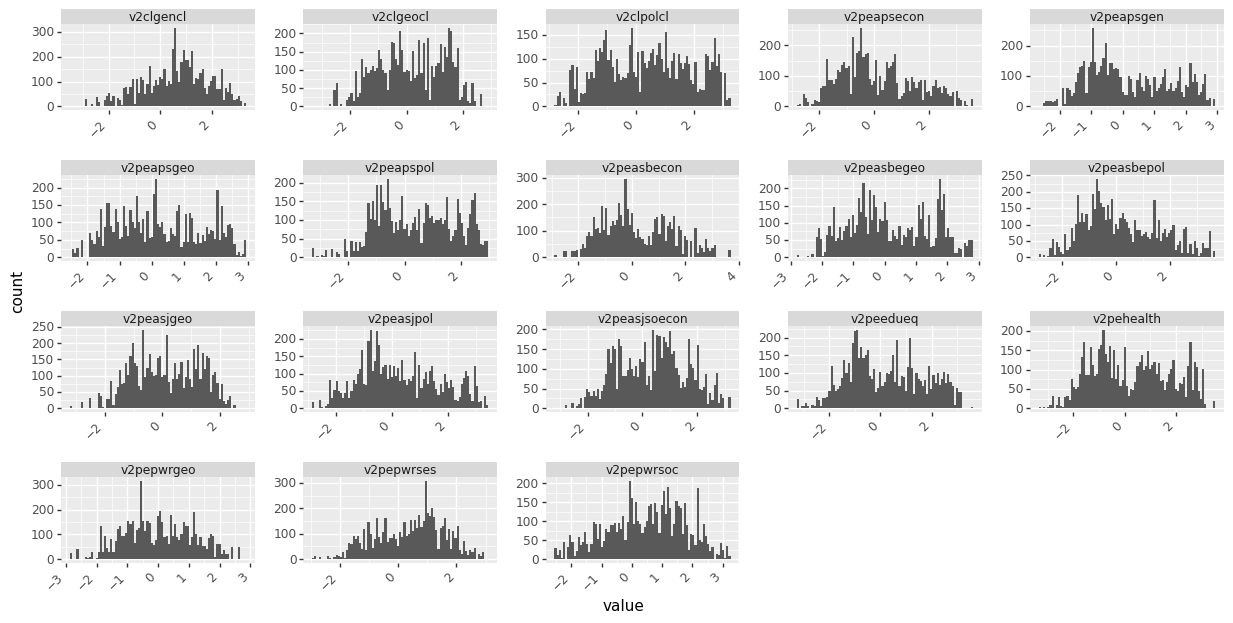

<ggplot: (346016010)>

In [499]:
(
    ggplot(a,aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable" , scales='free') +
    theme(figure_size=(15,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

## Make edits to full data

In [500]:
access_services.dropna(inplace = True)

## Split again

In [501]:
# split 
y = access_services.backsliding
X = access_services.drop(columns="backsliding")
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

## Model

In [502]:
# Build the modeling pipeline
pipe = Pipeline(steps=[('pre_process', preprocess),('model',None)])

search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators, max depth, and max features tuning param
    {'model' : [RF()],
    'model__max_depth':[6,7,8],
    'model__n_estimators':[500,1000,1500],
    'model__max_features': [5,10,15]},
    
]

# Grid Search to find the best parameters. The metric used for evaluation is ROC AUC
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

# fit the data with the model
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestClassifier(max_depth=8,
                                                           max_features=5,
                                                           n_estimators=1000)],
                          'model__max_depth': [6, 7, 8],
                          'model__max_features': [5, 10, 15],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='roc_auc')

In [503]:
#this is our out of sample AUC score
search.best_score_ 

0.7712475606489526

In [504]:
# what model performs the best
search.best_params_

{'model': RandomForestClassifier(max_depth=8, max_features=5, n_estimators=1000),
 'model__max_depth': 8,
 'model__max_features': 5,
 'model__n_estimators': 1000}

In [505]:
# now what happens if we try on the test data
best_mod = search.best_estimator_

In [506]:
pred_y = best_mod.predict(test_X)
m.roc_auc_score(test_y, pred_y)

0.556868919099027

In [507]:
confusion = m.confusion_matrix(test_y, pred_y)
print(confusion)
confusion_list.append(confusion)

[[1966    2]
 [ 108   14]]


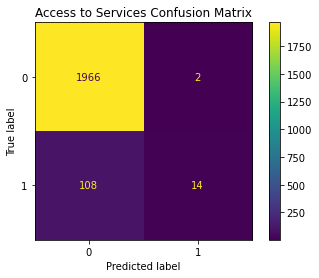

In [508]:
m.plot_confusion_matrix(best_mod, test_X, test_y)
plt.title("Access to Services Confusion Matrix")
plt.savefig("Figures/Access_Services_Confusion_matrix")

In [509]:
score = m.balanced_accuracy_score(test_y, pred_y)
print(score)
score_list.append(score)

0.556868919099027


In [510]:
bad_score = m.accuracy_score(test_y, pred_y)
bad_score_list.append(bad_score)

(array([9.50079745, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.49920255]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

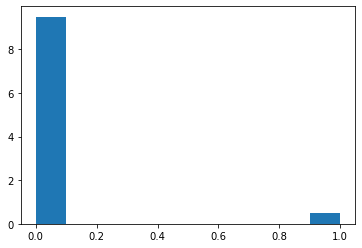

In [511]:
plt.hist(train_y, density=True)

## Split the data for civil liberties

In [512]:
# split 
y = civil_liberties.backsliding
X = civil_liberties.drop(columns="backsliding")
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

## Explore the training data

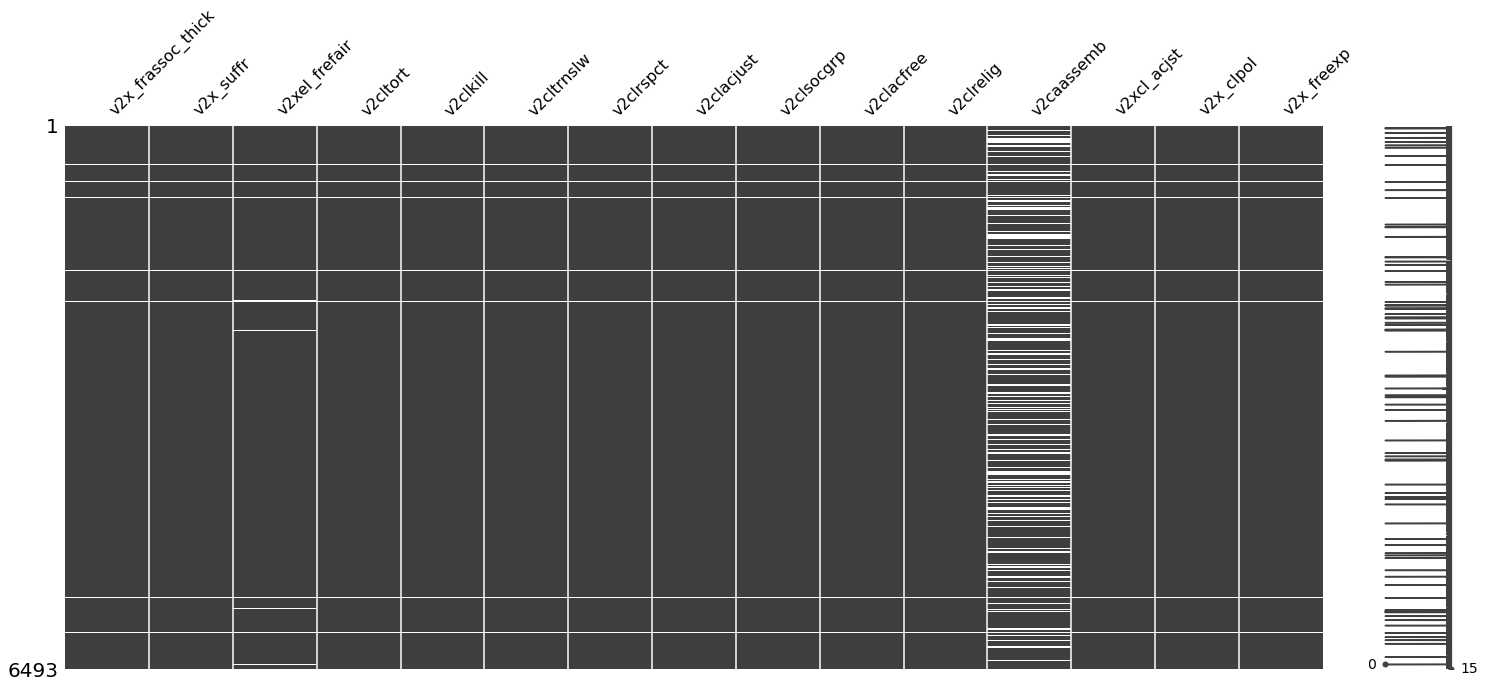

In [513]:
# missingness
miss.matrix(train_X)

In [514]:
train_X.isna().sum()

v2x_frassoc_thick      79
v2x_suffr              79
v2xel_frefair          93
v2cltort               79
v2clkill               79
v2cltrnslw             79
v2clrspct              79
v2clacjust             79
v2clsocgrp             79
v2clacfree             79
v2clrelig              79
v2caassemb           1648
v2xcl_acjst            79
v2x_clpol              79
v2x_freexp             79
dtype: int64

In [515]:
train_X.dropna(inplace=True)

In [516]:
train_X.describe()

,v2x_frassoc_thick,v2x_suffr,v2xel_frefair,v2cltort,v2clkill,v2cltrnslw,v2clrspct,v2clacjust,v2clsocgrp,v2clacfree,v2clrelig,v2caassemb,v2xcl_acjst,v2x_clpol,v2x_freexp
count,4832.000000,4832.000000,4832.000000,4832.000000,4832.000000,4832.000000,4832.000000,4832.000000,4832.000000,4832.000000,4832.000000,4832.000000,4832.000000,4832.000000,4832.000000
mean,0.529380,0.955680,0.458657,0.259107,0.492744,0.361206,0.074469,0.803695,0.520453,0.425398,0.546013,0.361882,0.562291,0.562123,0.552665
std,0.337947,0.183728,0.342434,1.614993,1.627537,1.463290,1.483454,1.207208,1.316690,1.658492,1.510327,1.612522,0.290147,0.332890,0.323622
min,0.021000,0.000000,0.000000,-3.118000,-3.587000,-3.625000,-3.368000,-2.535000,-3.033000,-3.327000,-3.965000,-3.123000,0.005000,0.010000,0.011000
25%,0.145000,1.000000,0.148000,-0.994000,-0.716000,-0.763000,-0.985000,0.138000,-0.552000,-0.822000,-0.537500,-0.997000,0.288750,0.218750,0.238000
50%,0.617000,1.000000,0.423000,0.226000,0.575000,0.185500,-0.213000,0.935000,0.702500,0.613000,1.075000,0.456000,0.588000,0.620000,0.603500
75%,0.864000,1.000000,0.811750,1.598250,1.951000,1.462000,0.981000,1.629000,1.536000,1.788000,1.739000,1.740750,0.819000,0.891250,0.869000
max,0.954000,1.000000,0.985000,3.321000,3.071000,3.471000,3.607000,3.209000,3.079000,3.287000,2.823000,3.061000,0.991000,0.983000,0.988000


In [517]:
a = train_X.melt()

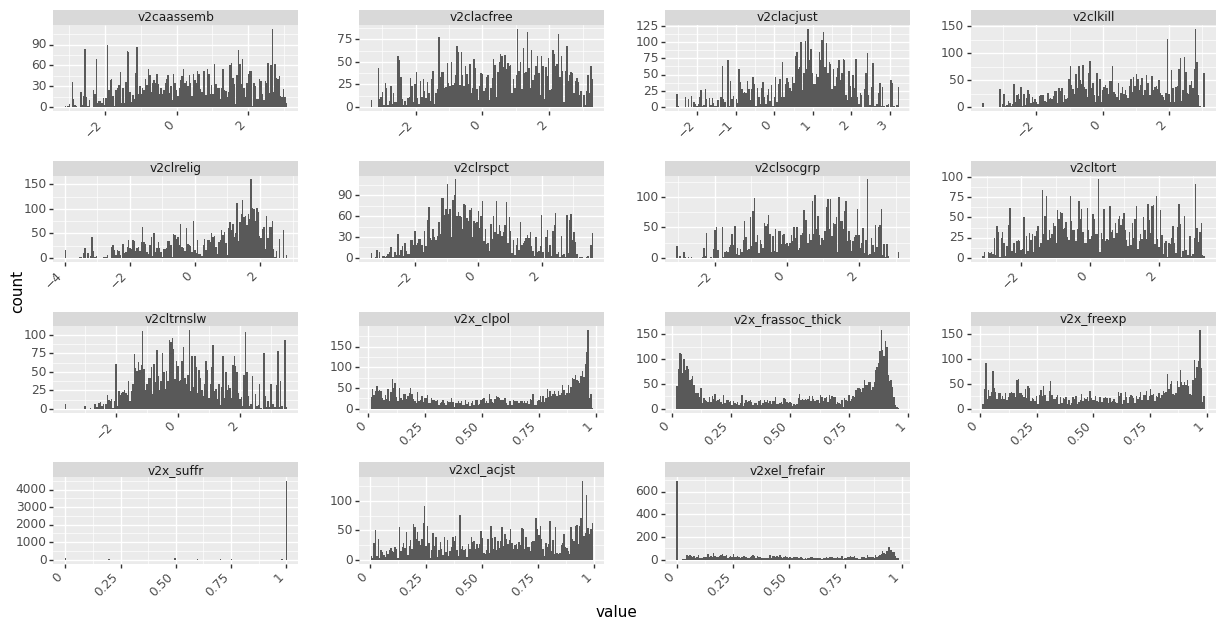

<ggplot: (313618652)>

In [518]:
(
    ggplot(a,aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable" , scales='free') +
    theme(figure_size=(15,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

## Make edits to full data

In [519]:
civil_liberties.dropna(inplace=True)

## Split the data again

In [520]:
# split 
y = civil_liberties.backsliding
X = civil_liberties.drop(columns="backsliding")
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

## Model

In [521]:
# Build the modeling pipeline
pipe = Pipeline(steps=[('pre_process', preprocess),('model',None)])

search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators, max depth, and max features tuning param
    {'model' : [RF()],
    'model__max_depth':[6,7,8],
    'model__n_estimators':[500,1000,1500],
    'model__max_features': [5,10,15]},
    
]

# Grid Search to find the best parameters. The metric used for evaluation is ROC AUC
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

# fit the data with the model
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestClassifier(max_depth=8,
                                                           max_features=5,
                                                           n_estimators=1000)],
                          'model__max_depth': [6, 7, 8],
                          'model__max_features': [5, 10, 15],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='roc_auc')

In [522]:
#this is our out of sample AUC score
search.best_score_ 

0.768665640053944

In [523]:
# what model performs the best
search.best_params_

{'model': RandomForestClassifier(max_depth=8, max_features=5, n_estimators=1000),
 'model__max_depth': 8,
 'model__max_features': 5,
 'model__n_estimators': 1000}

In [524]:
# now what happens if we try on the test data
best_mod = search.best_estimator_

In [525]:
pred_y = best_mod.predict(test_X)
m.roc_auc_score(test_y, pred_y)

0.5125

In [526]:
confusion = m.confusion_matrix(test_y, pred_y)
print(confusion)
confusion_list.append(confusion)

[[1539    0]
 [  78    2]]


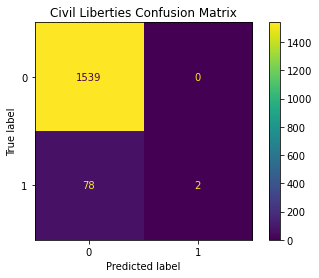

In [527]:
m.plot_confusion_matrix(best_mod, test_X, test_y)
plt.title("Civil Liberties Confusion Matrix")
plt.savefig("Figures/Civil_Liberties_Confusion_matrix")

In [528]:
score = m.balanced_accuracy_score(test_y, pred_y)
print(score)
score_list.append(score)

0.5125


In [529]:
bad_score = m.accuracy_score(test_y, pred_y)
bad_score_list.append(bad_score)

## Split the data for civil society

In [530]:
# split 
y = civil_society.backsliding
X = civil_society.drop(columns="backsliding")
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

## Explore the training data

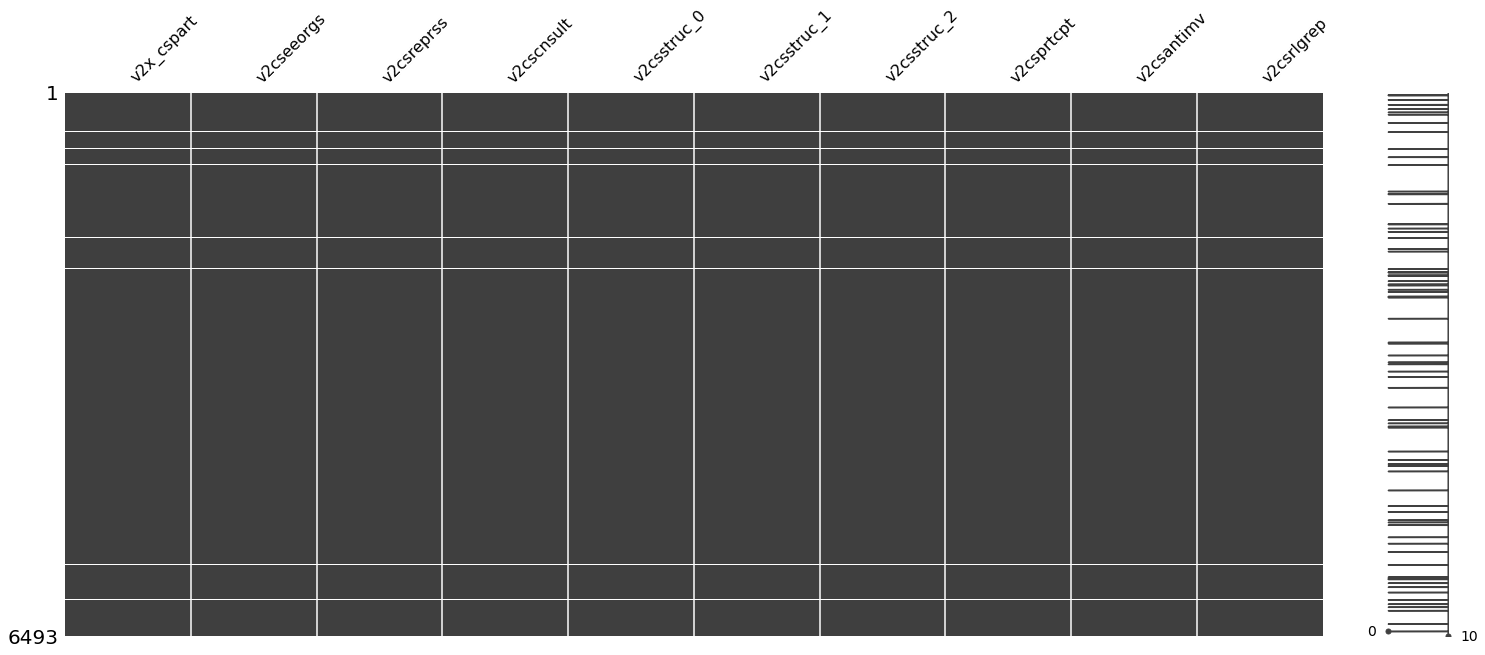

In [531]:
# missingness
miss.matrix(train_X)

In [532]:
train_X.isna().sum()

v2x_cspart     79
v2cseeorgs     79
v2csreprss     79
v2cscnsult     79
v2csstruc_0    79
v2csstruc_1    79
v2csstruc_2    79
v2csprtcpt     79
v2csantimv     79
v2csrlgrep     79
dtype: int64

In [533]:
train_X.dropna(inplace=True)

In [534]:
train_X.describe()

,v2x_cspart,v2cseeorgs,v2csreprss,v2cscnsult,v2csstruc_0,v2csstruc_1,v2csstruc_2,v2csprtcpt,v2csantimv,v2csrlgrep
count,6414.000000,6414.000000,6414.000000,6414.000000,6414.000000,6414.000000,6414.000000,6414.000000,6414.000000,6414.000000
mean,0.543681,0.395222,0.367007,0.242649,0.189307,0.297515,0.435370,0.232259,-0.469650,0.483751
std,0.287874,1.564283,1.582388,1.451540,0.282678,0.236204,0.272553,1.484527,1.281226,1.447304
min,0.016000,-3.230000,-3.599000,-2.444000,0.000000,0.000000,0.000000,-3.209000,-2.989000,-4.152000
25%,0.286250,-0.869000,-0.858000,-0.929250,0.000000,0.133000,0.200000,-0.693000,-1.383750,-0.517000
50%,0.565000,0.511000,0.329000,0.221000,0.000000,0.250000,0.400000,0.504000,-0.627500,0.735500
75%,0.806000,1.779000,1.712000,1.289000,0.333000,0.429000,0.625000,1.339000,0.511000,1.826000
max,0.986000,3.607000,3.210000,3.450000,1.000000,1.000000,1.000000,2.920000,4.016000,2.617000


In [535]:
a = train_X.melt()

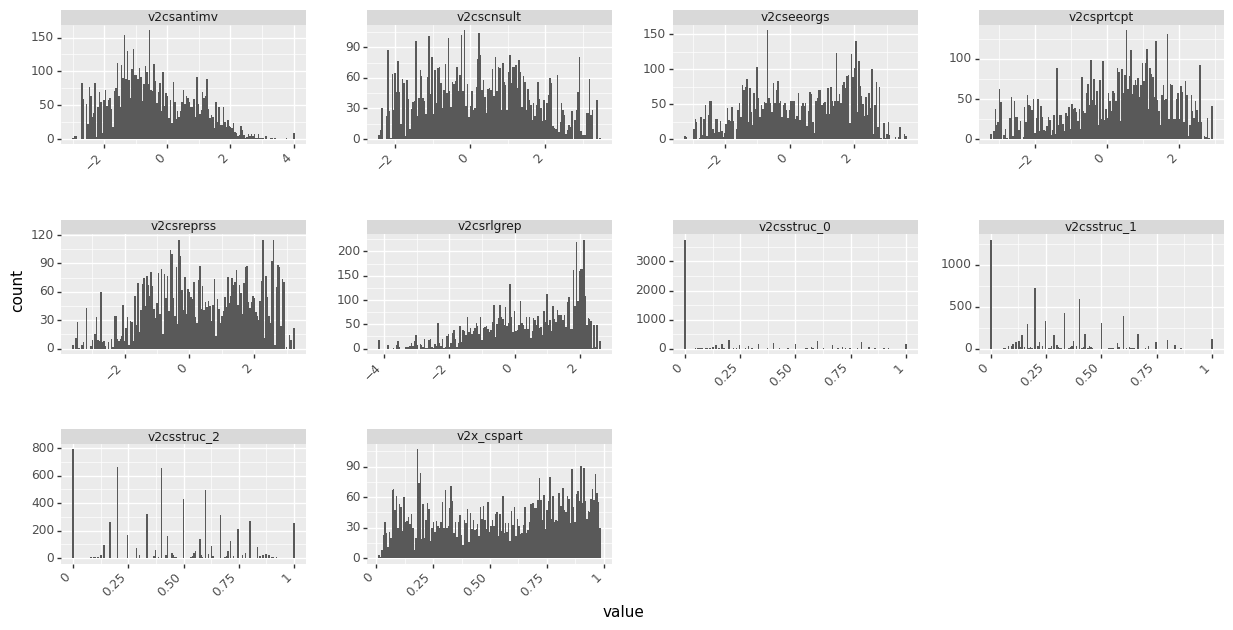

<ggplot: (360844261)>

In [536]:
(
    ggplot(a,aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable" , scales='free') +
    theme(figure_size=(15,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

## Make edits to full data

In [537]:
civil_society.dropna(inplace = True)

## Split again

In [538]:
# split 
y = civil_society.backsliding
X = civil_society.drop(columns="backsliding")
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

## Model

In [539]:
# Build the modeling pipeline
pipe = Pipeline(steps=[('pre_process', preprocess),('model',None)])

search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators, max depth, and max features tuning param
    {'model' : [RF()],
    'model__max_depth':[6,7,8],
    'model__n_estimators':[500,1000,1500],
    'model__max_features': [5,10,15]},
    
]

# Grid Search to find the best parameters. The metric used for evaluation is ROC AUC
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

# fit the data with the model
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestClassifier(max_depth=8,
                                                           max_features=5,
                                                           n_estimators=500)],
                          'model__max_depth': [6, 7, 8],
                          'model__max_features': [5, 10, 15],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='roc_auc')

In [540]:
#this is our out of sample AUC score
search.best_score_ 

0.7788211225927113

In [541]:
# what model performs the best
search.best_params_

{'model': RandomForestClassifier(max_depth=8, max_features=5, n_estimators=500),
 'model__max_depth': 8,
 'model__max_features': 5,
 'model__n_estimators': 500}

In [542]:
# now what happens if we try on the test data
best_mod = search.best_estimator_

In [543]:
pred_y = best_mod.predict(test_X)
m.roc_auc_score(test_y, pred_y)

0.5442477876106194

In [544]:
confusion = m.confusion_matrix(test_y, pred_y)
print(confusion)
confusion_list.append(confusion)

[[2025    0]
 [ 103   10]]


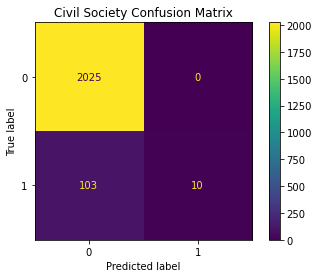

In [545]:
m.plot_confusion_matrix(best_mod, test_X, test_y)
plt.title("Civil Society Confusion Matrix")
plt.savefig("Figures/Civil_Society_Confusion_matrix")

In [546]:
score = m.balanced_accuracy_score(test_y, pred_y)
print(score)
score_list.append(score)

0.5442477876106194


In [547]:
bad_score = m.accuracy_score(test_y, pred_y)
bad_score_list.append(bad_score)

## Split the data for media

In [548]:
# split 
y = media.backsliding
X = media.drop(columns="backsliding")
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

## Explore Training Data

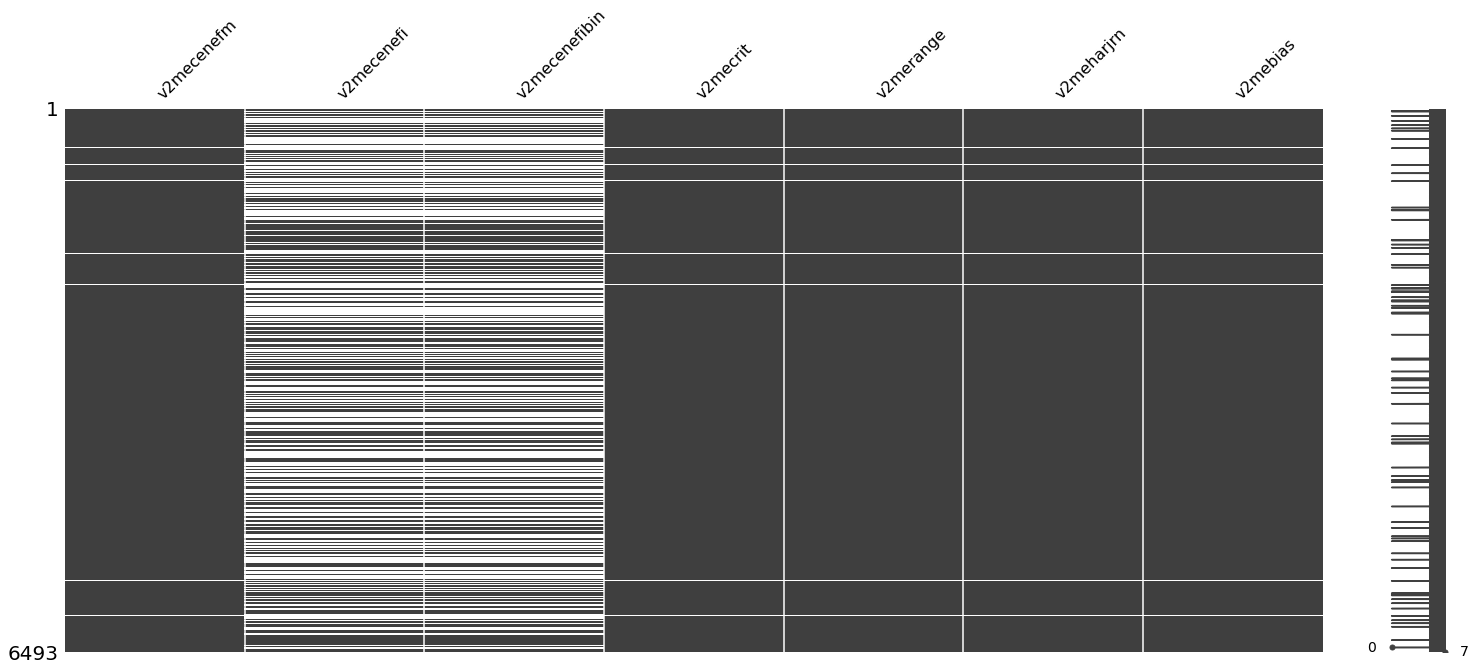

In [549]:
# missingness
miss.matrix(train_X)

In [550]:
train_X.isna().sum()

v2mecenefm         79
v2mecenefi       3584
v2mecenefibin    3584
v2mecrit           79
v2merange          79
v2meharjrn         79
v2mebias           79
dtype: int64

In [551]:
train_X.dropna(inplace=True)

In [552]:
train_X.describe()

,v2mecenefm,v2mecenefi,v2mecenefibin,v2mecrit,v2merange,v2meharjrn,v2mebias
count,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000
mean,0.689193,0.302530,0.069258,0.902405,0.860216,0.679660,0.832399
std,1.463233,1.362792,1.002249,1.375801,1.343735,1.336267,1.351526
min,-3.025000,-4.205000,-5.054000,-3.327000,-3.201000,-3.181000,-3.283000
25%,-0.316000,-0.541000,0.419000,0.158000,0.157000,-0.189000,0.236000
50%,0.766000,0.755000,0.452000,1.123000,1.278000,0.696000,1.110000
75%,1.790000,1.501000,0.473000,2.060000,1.831000,1.660000,1.828000
max,3.327000,1.846000,0.549000,3.036000,2.714000,3.917000,3.040000


In [553]:
a = train_X.melt()

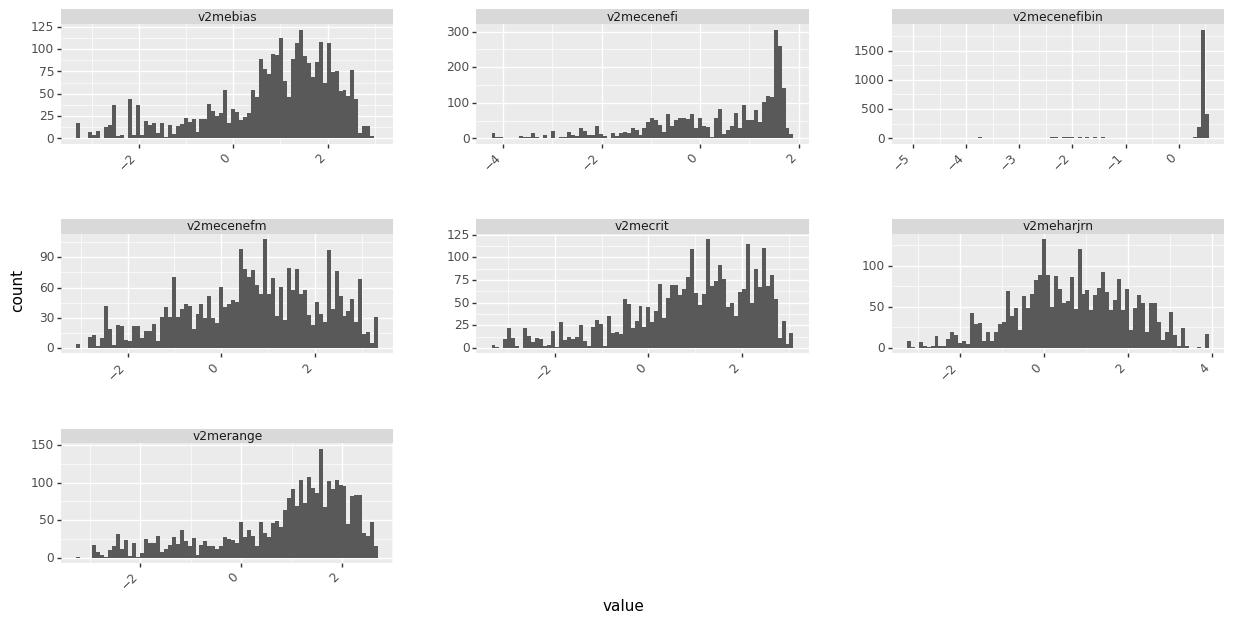

<ggplot: (359683702)>

In [554]:
(
    ggplot(a,aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable" , scales='free') +
    theme(figure_size=(15,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

## Edit Full Data

In [555]:
media.dropna(inplace=True)

## Split again

In [556]:
# split 
y = media.backsliding
X = media.drop(columns="backsliding")
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

## Model

In [557]:
# Build the modeling pipeline
pipe = Pipeline(steps=[('pre_process', preprocess),('model',None)])

search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators, max depth, and max features tuning param
    {'model' : [RF()],
    'model__max_depth':[6,7,8],
    'model__n_estimators':[500,1000,1500],
    'model__max_features': [5,10,15]},
    
]

# Grid Search to find the best parameters. The metric used for evaluation is ROC AUC
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

# fit the data with the model
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestClassifier(max_depth=8,
                                                           max_features=5,
                                                           n_estimators=500)],
                          'model__max_depth': [6, 7, 8],
                          'model__max_features': [5, 10, 15],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='roc_auc')

In [558]:
#this is our out of sample AUC score
search.best_score_ 

0.7730609736528387

In [559]:
# what model performs the best
search.best_params_

{'model': RandomForestClassifier(max_depth=8, max_features=5, n_estimators=500),
 'model__max_depth': 8,
 'model__max_features': 5,
 'model__n_estimators': 500}

In [560]:
# now what happens if we try on the test data
best_mod = search.best_estimator_

In [561]:
pred_y = best_mod.predict(test_X)
m.roc_auc_score(test_y, pred_y)

0.5952380952380952

In [562]:
confusion = m.confusion_matrix(test_y, pred_y)
print(confusion)
confusion_list.append(confusion)

[[924   0]
 [ 34   8]]


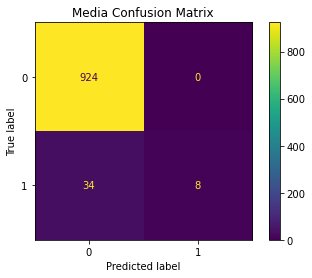

In [563]:
m.plot_confusion_matrix(best_mod, test_X, test_y)
plt.title("Media Confusion Matrix")
plt.savefig("Figures/Media_Confusion_matrix")

In [564]:
score = m.balanced_accuracy_score(test_y, pred_y)
print(score)
score_list.append(score)

0.5952380952380952


In [565]:
bad_score = m.accuracy_score(test_y, pred_y)
bad_score_list.append(bad_score)

## Split Econ Data

In [566]:
# split 
y = econ.backsliding
X = econ.drop(columns="backsliding")
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

## Explore Training Data


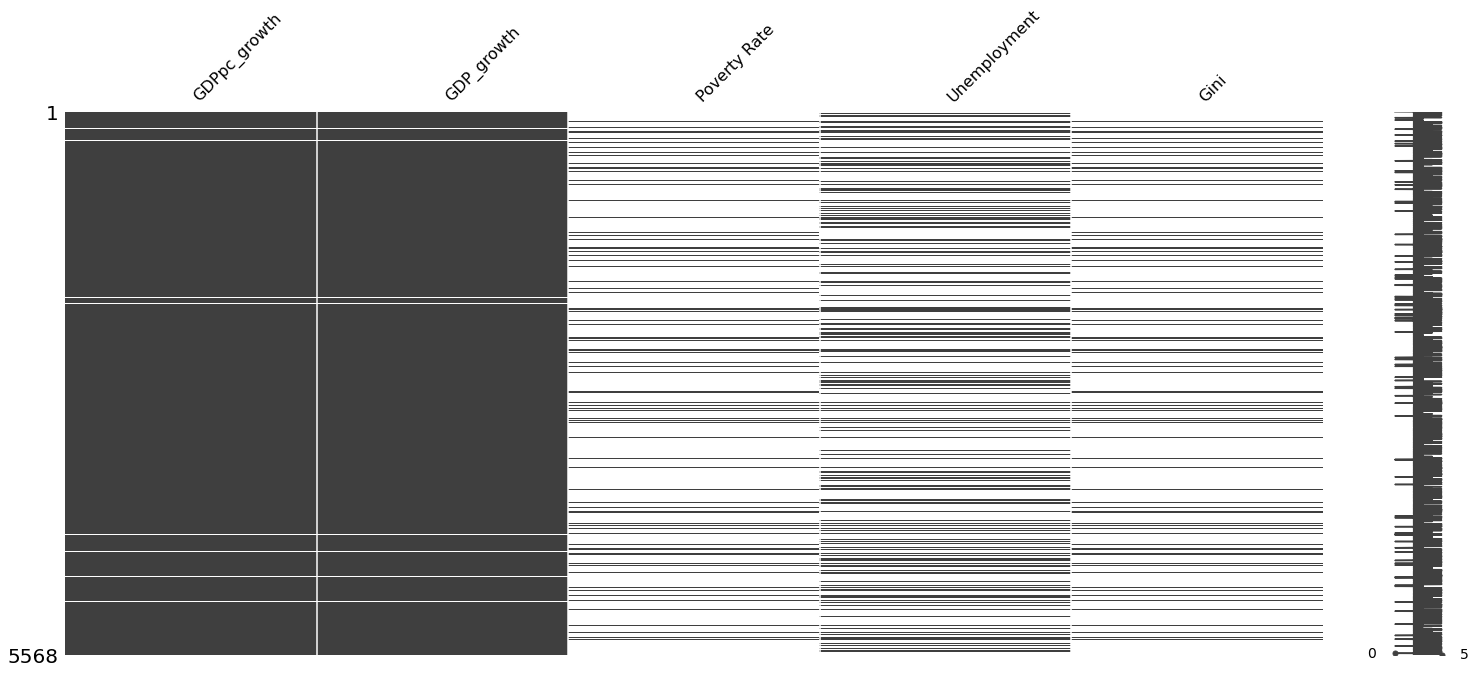

In [567]:
# missingness
miss.matrix(train_X)

In [568]:
train_X.isna().sum()

GDPpc_growth      77
GDP_growth        77
Poverty Rate    4707
Unemployment    3875
Gini            4712
dtype: int64

In [569]:
train_X.dropna(inplace=True)

In [570]:
train_X.describe()

,GDPpc_growth,GDP_growth,Poverty Rate,Unemployment,Gini
count,600.000000,600.000000,600.000000,600.000000,600.000000
mean,2.450721,3.347772,6.059833,0.082203,38.145667
std,4.208892,4.293156,11.137406,0.049412,9.342980
min,-16.600000,-17.000000,0.000000,0.005800,22.900000
25%,0.528250,1.507500,0.200000,0.047250,31.400000
50%,2.680000,3.680000,1.000000,0.074050,35.500000
75%,4.707500,5.760000,7.100000,0.101000,44.825000
max,23.600000,25.200000,77.400000,0.322000,64.800000


In [571]:
a = train_X.melt()

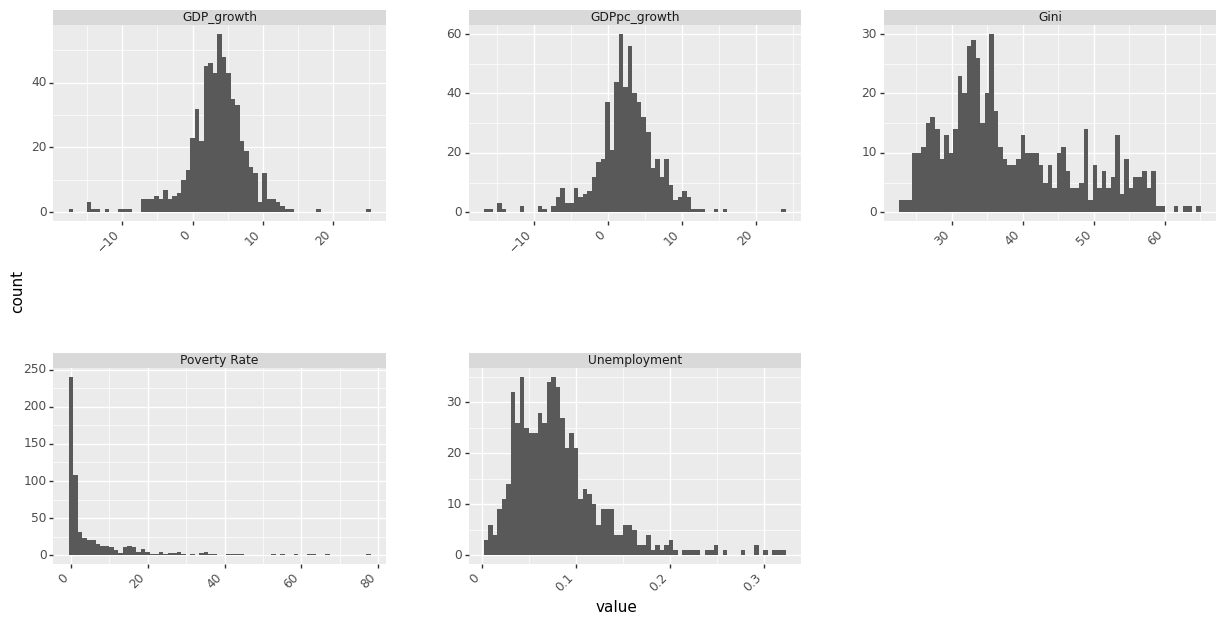

<ggplot: (360472869)>

In [572]:
(
    ggplot(a,aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable" , scales='free') +
    theme(figure_size=(15,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

## Edit Full Data

In [573]:
econ.dropna(inplace=True)

## Split again

In [574]:
# split 
y = econ.backsliding
X = econ.drop(columns="backsliding")
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

## Model

In [575]:
# Build the modeling pipeline
pipe = Pipeline(steps=[('pre_process', preprocess),('model',None)])

search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators, max depth, and max features tuning param
    {'model' : [RF()],
    'model__max_depth':[6,7,8],
    'model__n_estimators':[500,1000,1500],
    'model__max_features': [5,10,15]},
    
]

# Grid Search to find the best parameters. The metric used for evaluation is ROC AUC
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

# fit the data with the model
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier(n_neighbors=25)],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestClassifier()],
                          'model__max_depth': [6, 7, 8],
                          'model__max_features': [5, 10, 15],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='roc_auc')

In [576]:
#this is our out of sample AUC score
search.best_score_ 

0.5627569553212167

In [577]:
# what model performs the best
search.best_params_

{'model': KNeighborsClassifier(n_neighbors=25), 'model__n_neighbors': 25}

In [578]:
# now what happens if we try on the test data
best_mod = search.best_estimator_

In [579]:
pred_y = best_mod.predict(test_X)
m.roc_auc_score(test_y, pred_y)

0.5

In [580]:
confusion = m.confusion_matrix(test_y, pred_y)
print(confusion)
confusion_list.append(confusion)

[[204   0]
 [  2   0]]


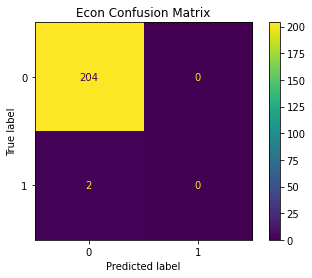

In [581]:
m.plot_confusion_matrix(best_mod, test_X, test_y)
plt.title("Econ Confusion Matrix")
plt.savefig("Figures/Econ_Confusion_matrix")

In [582]:
score = m.balanced_accuracy_score(test_y, pred_y)
print(score)
score_list.append(score)

0.5


In [583]:
bad_score = m.accuracy_score(test_y, pred_y)
bad_score_list.append(bad_score)

## Plot list of scores

In [584]:
print(max(score_list))
print(min(score_list))
print(np.average(score_list))

0.5952380952380952
0.5
0.5404108482339117


In [585]:
print(max(bad_score_list))
print(min(bad_score_list))
print(np.average(bad_score_list))

0.9902912621359223
0.9473684210526315
0.9594746931990858


In [586]:
confusion_list

[array([[1346,    3],
        [  67,    5]]),
 array([[1966,    2],
        [ 108,   14]]),
 array([[1539,    0],
        [  78,    2]]),
 array([[2025,    0],
        [ 103,   10]]),
 array([[924,   0],
        [ 34,   8]]),
 array([[204,   0],
        [  2,   0]])]

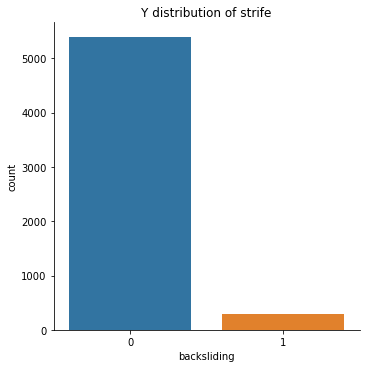

In [587]:
sns.catplot(x = "backsliding", kind="count", data=strife)
plt.title("Y distribution of strife")
plt.savefig("Figures/y_distribution", bbox_inches='tight')

## Create big set with everything